## Do Whales Move the Market

### Environment and API Key Setup
Set up environment variables and load API keys for data access.

In [ ]:
# ### Environment and API Key Setup
# Set up environment variables and load API keys for data access.
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
COINGECK_API = os.getenv('GECKO_API')  # CoinGecko API key (if needed)
#ETHERSCAN_API_KEY = os.getenv('ETHERSCAN_API')  # Etherscan API key (if needed)
API_KEY = os.getenv('DUNE_CUSTOM_API')  # Dune custom endpoint API key


### Fetch Whale Transaction Data
Retrieve Ethereum whale transaction data using Dune custom endpoint.

In [ ]:
# ### Fetch Whale Transaction Data
# Retrieve Ethereum whale transaction data using Dune custom endpoint.
from dune_client.client import DuneClient
import pandas as pd

# Initialize Dune client
dune = DuneClient(API_KEY)

# Fetch whale transaction data
response = dune.get_custom_endpoint_result(
  "firstbml",
  "ethereum-whale-transactions",
  limit=100
)

# Convert response to DataFrame
df = pd.DataFrame(response.get_rows())

# Format whale volume column as currency
if 'total_whale_volume_usd' in df.columns:
    df['total_whale_volume_usd'] = df['total_whale_volume_usd'].astype(float).map(lambda x: f"${x:,.2f}")

print(df.head(30))  # Display first 30 rows

                            day  num_large_trades total_whale_volume_usd
0   2025-08-06 00:00:00.000 UTC                 4            $508,540.58
1   2025-08-05 00:00:00.000 UTC                20          $3,277,071.51
2   2025-08-04 00:00:00.000 UTC                16          $2,334,053.05
3   2025-08-03 00:00:00.000 UTC                 3            $412,037.49
4   2025-08-02 00:00:00.000 UTC                59         $13,847,771.00
5   2025-08-01 00:00:00.000 UTC                66          $9,105,824.67
6   2025-07-31 00:00:00.000 UTC                11          $1,463,947.98
7   2025-07-30 00:00:00.000 UTC                30          $4,857,900.82
8   2025-07-29 00:00:00.000 UTC                12          $1,572,358.72
9   2025-07-28 00:00:00.000 UTC                11          $1,486,614.01
10  2025-07-27 00:00:00.000 UTC                12          $3,182,463.52
11  2025-07-26 00:00:00.000 UTC                14          $3,677,184.26
12  2025-07-25 00:00:00.000 UTC                66  

### Fetche the daily price of Ethereum (ETH) in USD for the last 30 days from the CoinGecko API

In [ ]:
# ### Fetch Ethereum Price Data
# Get daily Ethereum price data for the last 30 days from CoinGecko.
import requests
import pandas as pd

# Define CoinGecko endpoint and parameters
coingecko_url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
params = {
    "vs_currency": "usd",
    "days": "30",
    "interval": "daily"
}

# Fetch price data
cg_response = requests.get(coingecko_url, params=params)
cg_data = cg_response.json()

# Convert to DataFrame
eth_prices = pd.DataFrame(cg_data['prices'], columns=['timestamp', 'eth_price'])
eth_prices['timestamp'] = pd.to_datetime(eth_prices['timestamp'], unit='ms')
eth_prices['date'] = eth_prices['timestamp'].dt.date
eth_prices = eth_prices[['date', 'eth_price']]


### Aggregate Whale Volume by Day
Process and aggregate whale transaction volume to daily totals.

In [ ]:
# ### Aggregate Whale Volume by Day
# Process and aggregate whale transaction volume to daily totals.
# Assuming df already has 'block_time' and 'total_whale_volume_usd'
df['block_time'] = pd.to_datetime(df['day'])  # Convert day to datetime
df['date'] = df['block_time'].dt.date  # Extract date

# Aggregate whale volume by day
# Handle both string and float types
if df['total_whale_volume_usd'].dtype == 'O':
    # If object, clean and convert
    daily_whale_volume = df.groupby('date')['total_whale_volume_usd'].apply(
        lambda x: pd.to_numeric(x.str.replace('[$,]', '', regex=True), errors='coerce').sum()
    ).reset_index()
else:
    # If already numeric
    daily_whale_volume = df.groupby('date')['total_whale_volume_usd'].sum().reset_index()
daily_whale_volume.columns = ['date', 'whale_volume_usd']  # Rename columns
print(daily_whale_volume.head(20))  # Display first 20 rows

          date  whale_volume_usd
0   2025-07-07        2056453.23
1   2025-07-08        4361661.66
2   2025-07-09       16933127.46
3   2025-07-10       34295046.32
4   2025-07-11       16492181.41
5   2025-07-12        2503366.85
6   2025-07-13        5284081.89
7   2025-07-14        7052569.89
8   2025-07-15       11476145.20
9   2025-07-16       36976706.85
10  2025-07-17       29736656.36
11  2025-07-18       46584355.70
12  2025-07-19        2983491.03
13  2025-07-20       15130898.07
14  2025-07-21        4444956.80
15  2025-07-22        7998046.82
16  2025-07-23       11327368.73
17  2025-07-24        8091064.34
18  2025-07-25        8888207.89
19  2025-07-26        3677184.26


### Format and Display Merged Data
Format whale volume and ETH price as currency and display sample merged data.

In [ ]:
# ### Format and Display Merged Data
# Format whale volume and ETH price as currency and display sample merged data.
# Merge price and whale volume data
merged = pd.merge(eth_prices, daily_whale_volume, on='date', how='inner')
# Format columns as currency and round
merged['whale_volume_usd'] = merged['whale_volume_usd'].round(2).map(lambda x: f"${x:,.2f}")
merged['eth_price'] = merged['eth_price'].round(2).map(lambda x: f"${x:,.2f}")

print(merged[['date', 'whale_volume_usd', 'eth_price']].head(30))  # Display first 30 rows

          date whale_volume_usd  eth_price
0   2025-07-08    $4,361,661.66  $2,543.63
1   2025-07-09   $16,933,127.46  $2,615.78
2   2025-07-10   $34,295,046.32  $2,772.58
3   2025-07-11   $16,492,181.41  $2,948.45
4   2025-07-12    $2,503,366.85  $2,958.85
5   2025-07-13    $5,284,081.89  $2,942.96
6   2025-07-14    $7,052,569.89  $2,974.27
7   2025-07-15   $11,476,145.20  $3,012.18
8   2025-07-16   $36,976,706.85  $3,133.07
9   2025-07-17   $29,736,656.36  $3,368.13
10  2025-07-18   $46,584,355.70  $3,481.88
11  2025-07-19    $2,983,491.03  $3,547.32
12  2025-07-20   $15,130,898.07  $3,594.32
13  2025-07-21    $4,444,956.80  $3,758.61
14  2025-07-22    $7,998,046.82  $3,765.45
15  2025-07-23   $11,327,368.73  $3,746.94
16  2025-07-24    $8,091,064.34  $3,630.05
17  2025-07-25    $8,888,207.89  $3,708.43
18  2025-07-26    $3,677,184.26  $3,723.05
19  2025-07-27    $3,182,463.52  $3,742.43
20  2025-07-28    $1,486,614.01  $3,864.12
21  2025-07-29    $1,572,358.72  $3,786.30
22  2025-07

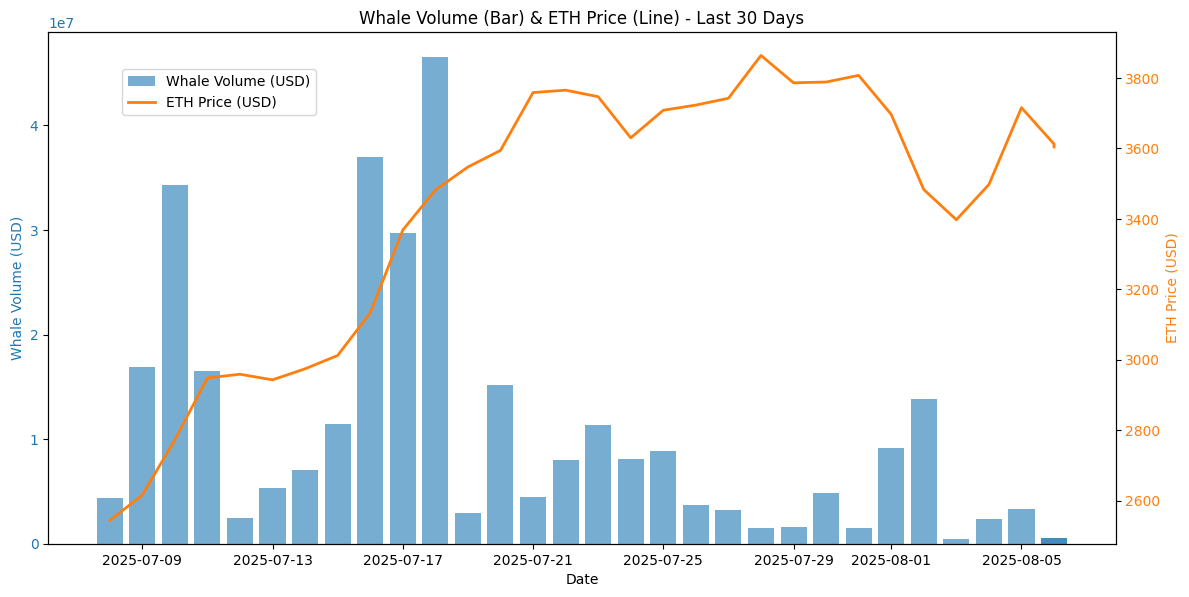

In [14]:
# Custom Visualization: Bar chart for whale volume and line chart for ETH price on the same plot
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(merged_corr['date'], merged_corr['whale_volume_usd'], color='tab:blue', alpha=0.6, label='Whale Volume (USD)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Whale Volume (USD)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(merged_corr['date'], merged_corr['eth_price'], color='tab:orange', label='ETH Price (USD)', linewidth=2)
ax2.set_ylabel('ETH Price (USD)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
fig.tight_layout()
plt.title('Whale Volume (Bar) & ETH Price (Line) - Last 30 Days')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

### Correlation Analysis
Calculate and print the correlation between whale volume and ETH price.

In [ ]:
# ### Correlation Analysis
# Calculate and print the correlation between whale volume and ETH price.
# Remove formatting for correlation calculation
merged_corr = pd.merge(eth_prices, daily_whale_volume, on='date', how='inner')
corr_value = merged_corr['whale_volume_usd'].corr(merged_corr['eth_price'])
print(f"Correlation between whale volume and ETH price (daily, last 30 days): {corr_value:.4f}")

Correlation between whale volume and ETH price (daily, last 30 days): -0.3273


### Visualization
Plot daily whale volume and ETH price with dual y-axes for trend analysis.

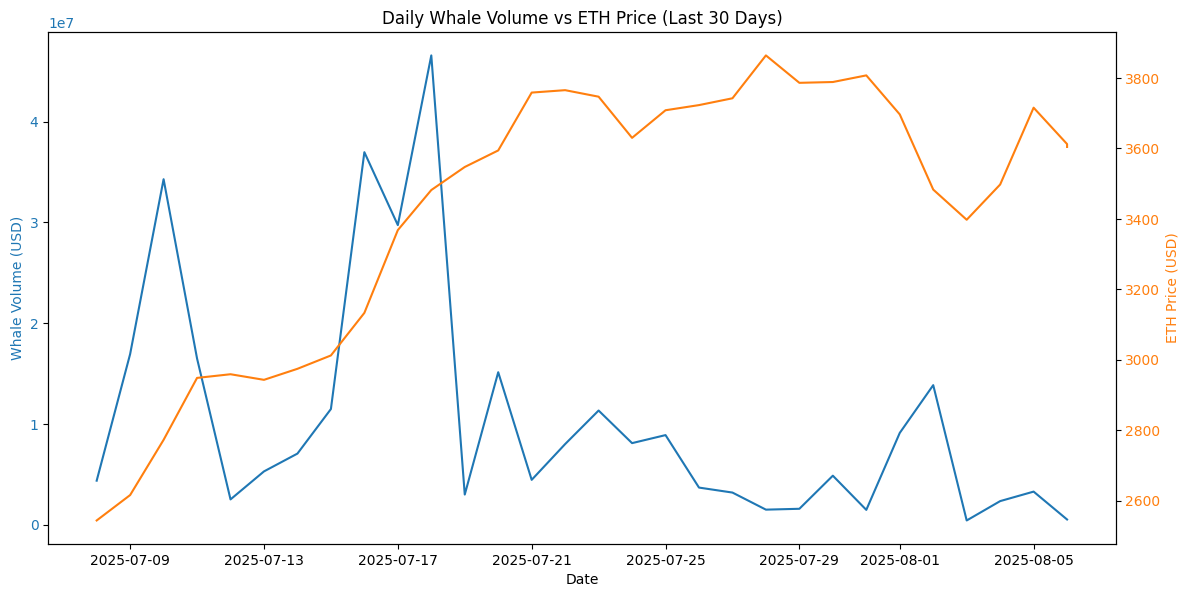

In [ ]:
# ### Visualization
# Plot daily whale volume and ETH price with dual y-axes for trend analysis.
import matplotlib.pyplot as plt

# Create plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Whale Volume (USD)', color='tab:blue')
ax1.plot(merged_corr['date'], merged_corr['whale_volume_usd'], color='tab:blue', label='Whale Volume (USD)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('ETH Price (USD)', color='tab:orange')
ax2.plot(merged_corr['date'], merged_corr['eth_price'], color='tab:orange', label='ETH Price (USD)')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Daily Whale Volume vs ETH Price (Last 30 Days)')
plt.show()